In [165]:
import numpy as np
import pandas as pd
import numpy.random as npr
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

In [2]:
!git clone https://github.com/pymc-devs/pymc-resources.git

Cloning into 'pymc-resources'...
remote: Enumerating objects: 2062, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 2062 (delta 38), reused 62 (delta 25), pack-reused 1976
Receiving objects: 100% (2062/2062), 450.29 MiB | 13.52 MiB/s, done.
Resolving deltas: 100% (966/966), done.
Updating files: 100% (271/271), done.


## Chapter

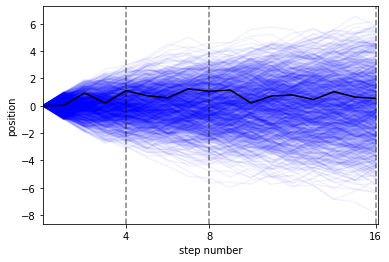

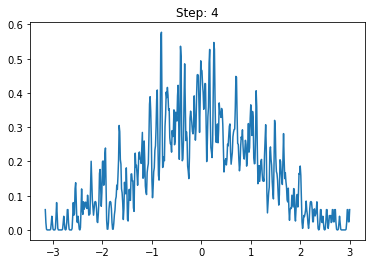

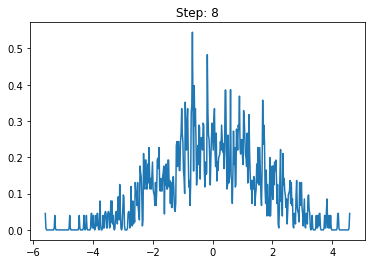

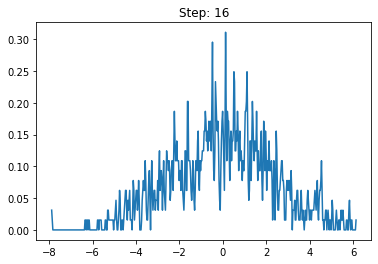

In [3]:
rng = np.random.default_rng(1)

steps = 16
reps = 1_000
show = [4, 8, 16]

x = np.zeros((reps, steps+1))
for rep in range(reps):
   x[rep, 1:]= np.cumsum(rng.uniform(-1, 1, steps))

fig, ax = plt.subplots()
plt.plot(range(0, steps + 1), x.T[:, :], c="b", alpha=0.05)
plt.plot(range(0, steps + 1), x.T[:, 0], c="k")
for step in show:
    plt.axvline(step, linestyle="--", c="k", alpha=0.5)

plt.xlabel("step number")
plt.ylabel("position")
ax.set_xticks(show)
plt.xlim(0, step + 0.1)
plt.show()

for step in show:
  fig, ax = plt.subplots()
  plt.plot(*az.kde(x[:, step], bw=0.01))
  plt.title(f"Step: {step}")

In [4]:
df = pd.read_csv("/content/pymc-resources/Rethinking_2/Data/Howell1.csv", delimiter=';')
df.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


In [6]:
df2 = df[df.age >= 18]

In [7]:
def scale_ends(lower, upper=None, val=10):
  if upper is None:
    return lower-val, lower+val
  return lower-val, upper+val

In [8]:
scale_ends(178, val=75)

(103, 253)

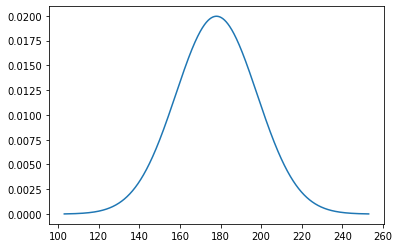

In [9]:
mean = 178
x = np.linspace(*scale_ends(mean, val=75), 1000)
plt.plot(x, stats.norm.pdf(x, mean, 20))
plt.show()

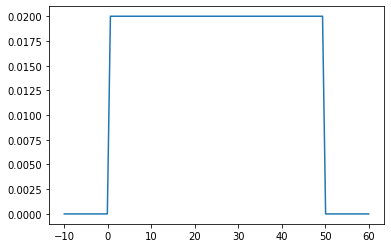

In [10]:
ends = [0, 50]
x = np.linspace(*scale_ends(*ends), 100)
plt.plot(x, stats.uniform.pdf(x, *ends));

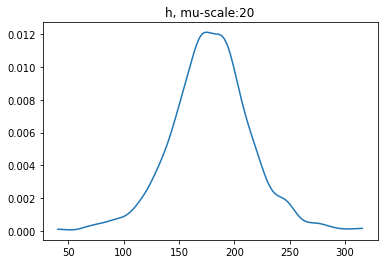

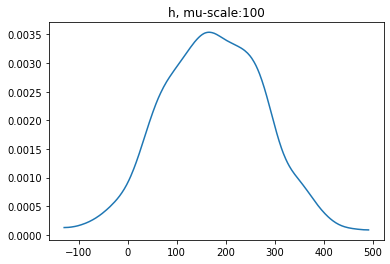

In [11]:
size= 1_000
sample_mu = stats.norm.rvs(size=size, loc=178, scale=20)
sample_sigma = stats.uniform.rvs(size=size, loc=0, scale=50)
h = stats.norm.rvs(size=size, loc=sample_mu, scale=sample_sigma)

plt.figure()
plt.plot(*az.kde(h))
plt.title("h, mu-scale:20")
plt.show()

h = stats.norm.rvs(size=size, loc=stats.norm.rvs(size=size, loc=178, scale=100), scale=sample_sigma)

plt.figure()
plt.plot(*az.kde(h))
plt.title("h, mu-scale:100")

plt.show()

### Grid approx

In [12]:
mu_grid = np.linspace(150, 160, 100)
sigma_grid = np.linspace(7, 9, 100)

xv, yv = np.meshgrid(mu_grid, sigma_grid, indexing='ij')
likelyhood = np.array([stats.norm.logpdf(df2['height'], loc=xv.flatten()[i], scale=yv.flatten()[i]) for i in range(yv.size)]).sum(axis=1)

posterior = (likelyhood + 
             stats.norm.logpdf(xv.flatten(), loc=178, scale=20) +
             stats.uniform.logpdf(yv.flatten(), loc=0, scale=50)
             )
posterior = np.exp(posterior - posterior.max())
posterior = posterior/posterior.sum()


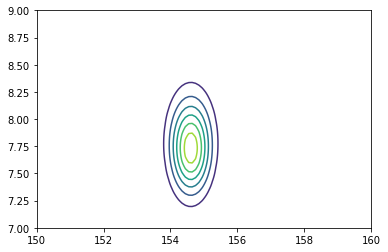

In [13]:
plt.contour(xv, yv, posterior.reshape(100, 100));

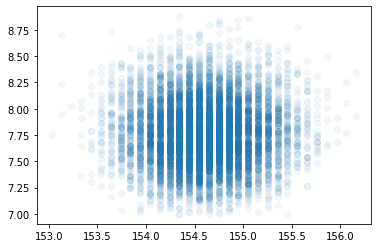

In [14]:
sample_rows = np.random.choice(np.arange(len(posterior)), size=10_000, replace=True, p=posterior)

mus = xv.flatten()[sample_rows]
sigmas = yv.flatten()[sample_rows]

plt.plot(mus, sigmas, "o", alpha=0.05)
plt.show()

In [15]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sigma=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df2.height.values)

In [16]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

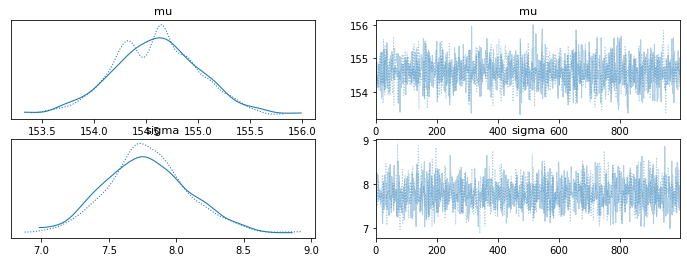

In [17]:
az.plot_trace(trace_4_1)
plt.show()

In [18]:
az.summary(trace_4_1, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu,154.60,0.41,153.85,155.41
sigma,7.78,0.31,7.22,8.37


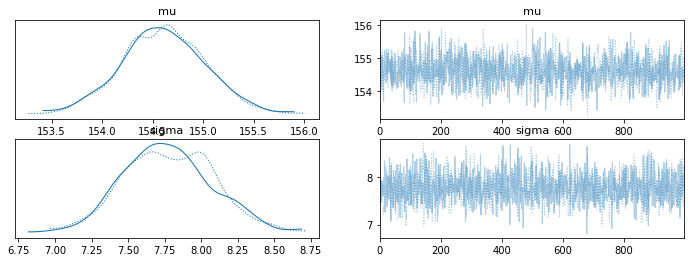

In [19]:
with pm.Model() as m4_2:
    mu = pm.Normal("mu", mu=178, sigma=20, initval=df2['height'].mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, initval=df2['height'].std())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df2.height.values)
    trace_4_2 = pm.sample(1000, tune=1000)
az.plot_trace(trace_4_2)
plt.show()

In [20]:
az.summary(trace_4_2, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu,154.61,0.42,153.76,155.35
sigma,7.78,0.31,7.22,8.35


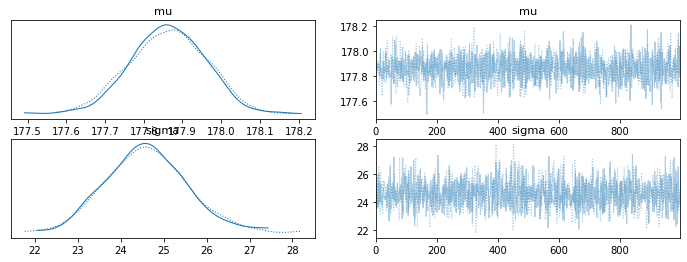

In [21]:
with pm.Model() as m4_3:
    mu = pm.Normal("mu", mu=178, sigma=0.1, initval=df2['height'].mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, initval=df2['height'].std())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df2.height.values)
    trace_4_3 = pm.sample(1000, tune=1000)
az.plot_trace(trace_4_3)
plt.show()

In [22]:
az.summary(trace_4_3, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu,177.86,0.10,177.67,178.04
sigma,24.61,0.95,22.79,26.36


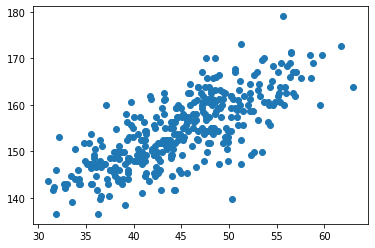

In [23]:
plt.scatter(df2['weight'], df2['height'])
plt.show()

In [24]:
def abline(slope, intercept, N=100):
    """Plot a line from slope and intercept"""
    x_vals = np.linspace(-50, 50, N)
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals,)

(0.0, 400.0)

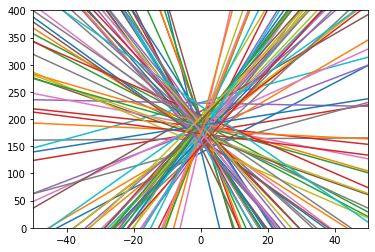

In [25]:
N = 100
As = stats.norm.rvs(scale=20, loc=178, size=N)
bs = stats.norm.rvs(scale=10, loc=0, size=N)
for a,b in zip(As,bs):
  abline(b, a)
plt.xlim(-50, 50)
plt.ylim(0, 400)

(0.0, 400.0)

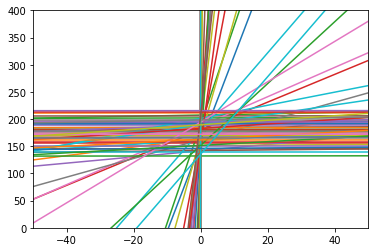

In [26]:
N = 100
As = stats.norm.rvs(scale=20, loc=178, size=N)
bs = stats.lognorm.rvs(s=10, scale=1, size=N)
for a,b in zip(As,bs):
  abline(b, a)
plt.xlim(-50, 50)
plt.ylim(0, 400)

In [27]:
with pm.Model() as m4_42:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50, initval=df2['height'].std())
    mu = a + b*(df2['weight'].values - df2['weight'].mean())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df2['height'].values)
    trace_4_42 = pm.sample(1000, tune=1000)


In [28]:
az.summary(trace_4_42, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,154.6,0.27,154.11,155.10
b,0.9,0.04,0.83,0.98
sigma,5.1,0.20,4.74,5.48


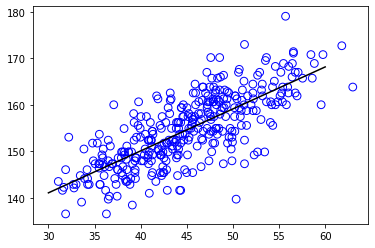

In [29]:
plt.scatter(df2['weight'], df2['height'], s=60, facecolors='none', edgecolor='b')
a = trace_4_42.posterior['a'].mean().values
b = trace_4_42.posterior['b'].mean().values
x_val = np.linspace(30, 60, 100)
plt.plot(x_val, a+b*(x_val-df2['weight'].mean()), color='black')
plt.show()

In [30]:
trace_4_42.posterior.to_dataframe().head()

a         b     sigma
chain draw                                
0     0     154.214503  0.777654  5.192626
      1     154.171009  0.810767  5.206753
      2     155.040466  0.939581  5.335839
      3     154.202321  0.874195  5.024845
      4     154.967681  0.894299  5.163485

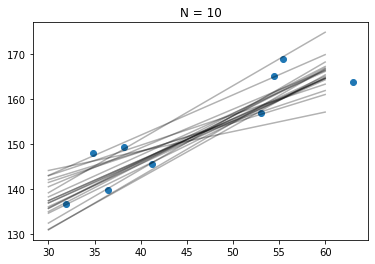

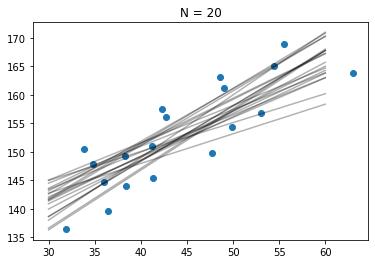

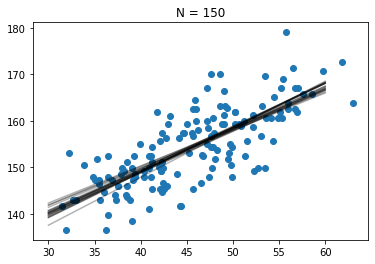

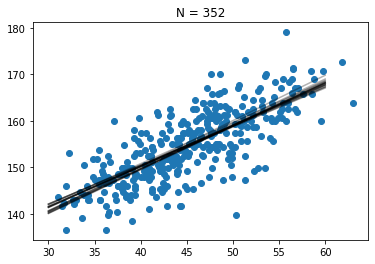

In [31]:
Ns = [10, 20, 150, 352]
for N in Ns:
  dN = df2[1:N]
  with pm.Model() as m4_48:
    a =pm.Normal("a", mu=178, sigma=20)
    b = pm.Lognormal("b", mu=0, sigma=1 )
    sigma = pm.Uniform("sigma", lower=0, upper=50, initval=dN['height'].std())
    mu = a + b*(dN['weight'].values - dN['weight'].mean())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=dN['height'].values)
    trace_4_48 = pm.sample(1000, tune=1000)
  
  trace_N = az.extract_dataset(trace_4_48)
  plt.figure()
  plt.title(f"N = {N}")
  plt.scatter(dN['weight'], dN['height'])
  for a, b in zip(trace_N['a'].values[:20], trace_N['b'].values[:20]):
    x_vals = np.linspace(30, 60, 20)
    plt.plot(x_vals, a+b*(x_vals-dN['weight'].mean()), alpha=0.3, color='black')
  plt.show()

In [32]:
data_4_42 = az.extract_dataset(trace_4_42)

In [33]:
weights = np.arange(25, 70, 1)
n_samples = trace_N.sizes['sample']
trace_sampled = data_4_42.isel(sample=range(0, n_samples, 10))
n_sampled = trace_sampled.sizes['sample']

mu_pred = np.zeros((len(weights), n_sampled))
for i, w in enumerate(weights):
  mu_pred[i] = trace_sampled['a'] + trace_sampled['b']*(w - df2['weight'].mean())

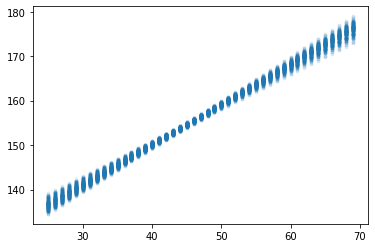

In [34]:
plt.plot(weights, mu_pred, "C0.", alpha=0.1)
plt.show()

/usr/local/lib/python3.9/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


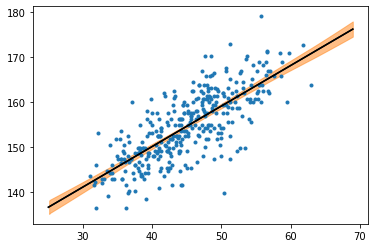

In [35]:
plt.plot(df2['weight'], df2['height'], '.')
plt.plot(weights, mu_pred.mean(axis=1), 'black')
az.plot_hdi(weights, mu_pred.T, hdi_prob=0.89)
plt.plot(weights, mu_pred.mean(axis=1), 'black')
plt.show()

In [36]:
samples = 100
rate = int(len(trace_4_42['posterior']['draw'])/samples)
sampled_data = trace_4_42.sel(draw=slice(None, None, rate))
with m4_42:
  height_preds = pm.sample_posterior_predictive(sampled_data)
height_preds['posterior_predictive']['height'].values

array([[[153.8461655 , 155.06850062, 137.73871906, ..., 167.14464223,
         166.45523609, 158.75724385],
        [156.35408315, 143.27458151, 145.02445415, ..., 157.94127465,
         165.86213511, 161.51462138],
        [158.54487861, 155.33265231, 135.56979581, ..., 168.15973223,
         165.06941182, 163.25579302],
        ...,
        [158.98215085, 142.68286202, 138.83730999, ..., 158.34611387,
         163.73600508, 159.19039067],
        [154.45919038, 154.73479933, 146.22236494, ..., 167.91806682,
         157.82811213, 166.64352747],
        [166.01037405, 147.37597624, 143.35628344, ..., 163.96312525,
         164.86198464, 156.98388978]],

       [[154.57477576, 142.10149329, 139.5946589 , ..., 158.4666081 ,
         167.7820508 , 166.29323892],
        [152.87990571, 151.56352127, 140.05429897, ..., 176.14035133,
         160.44203044, 163.42122651],
        [160.60857832, 138.89856403, 146.41315546, ..., 160.58525416,
         157.63523029, 165.75826526],
        ...,


In [37]:
az.hdi(height_preds['posterior_predictive']['height'].values, hdi_prob=0.89)

array([[148.95023709, 165.52031705],
       [138.85872051, 155.06850062],
       [135.44559566, 152.12642108],
       [152.95527584, 169.4254964 ],
       [144.11463703, 159.28283996],
       [161.39102409, 177.43179268],
       [139.74141799, 156.63135361],
       [157.83452107, 172.96656498],
       [136.69070104, 152.50750787],
       [155.7436452 , 171.85802337],
       [150.16901987, 167.39791438],
       [145.95471468, 160.92997629],
       [137.80681896, 153.92188511],
       [149.55951189, 164.54626967],
       [138.13796719, 152.58616537],
       [147.74420149, 164.68356078],
       [143.9795803 , 159.92664348],
       [141.14688772, 157.10423535],
       [151.39406487, 168.10879109],
       [144.92216962, 161.90563177],
       [136.87200535, 152.79292583],
       [142.24166524, 157.16789945],
       [138.36655605, 154.25539496],
       [142.13051188, 158.28604015],
       [153.8029642 , 170.92337756],
       [140.12390312, 155.26563636],
       [141.93678873, 157.95968971],
 

/usr/local/lib/python3.9/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


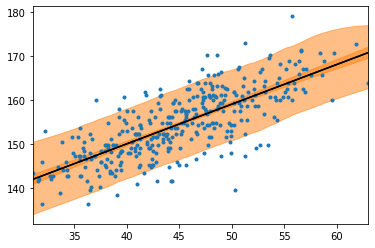

In [38]:
plt.plot(df2['weight'], df2['height'], '.')
plt.plot(weights, mu_pred.mean(axis=1), 'black')
ax = az.plot_hdi(weights, mu_pred.T, hdi_prob=0.89)
az.plot_hdi(df2['weight'], height_preds['posterior_predictive']['height'], ax=ax, hdi_prob=0.89)
plt.plot(weights, mu_pred.mean(axis=1), 'black')
plt.xlim(df2.weight.min(), df2.weight.max());
plt.show()

Higher dim

In [39]:
df_weights = (df['weight'] - df['weight'].mean()) / df['weight'].std()
df_weights_sq = df_weights**2

In [40]:
with pm.Model() as m_quadratic:
  a = pm.Normal('a', mu=178, sigma=20)
  b1 = pm.Lognormal('b1', mu=0, sigma=1)
  b2 = pm.Normal('b2', mu=0, sigma=1)
  sigma = pm.Uniform('sigma', lower=0, upper=50)
  mu = pm.Deterministic("mu", a + b1*df_weights.values + df_weights_sq.values*b2)
  h = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'].values)
  trace_4_5 = pm.sample(1000, tune=1000)

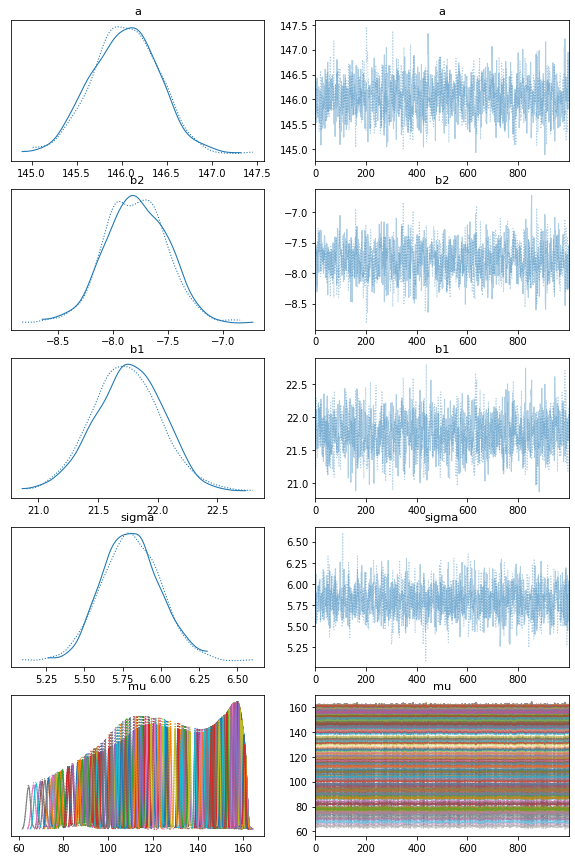

In [41]:
az.plot_trace(trace_4_5, figsize=(10,15))
plt.show()

In [42]:
mu_pred = trace_4_5.posterior['mu']
with m_quadratic:
  heights_pred = pm.sample_posterior_predictive(trace_4_5.sel(draw=slice(None, None, 10)))


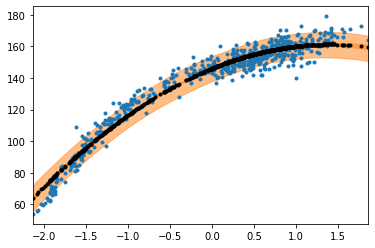

In [43]:
plt.plot(df_weights, df['height'], '.')
ax = az.plot_hdi(df_weights, mu_pred, hdi_prob=0.84)
az.plot_hdi(df_weights, heights_pred.posterior_predictive['height'], ax=ax, hdi_prob=0.84)
plt.plot(df_weights, mu_pred.mean(axis=0).mean(axis=0), '.', color='black')
plt.xlim(df_weights.min(), df_weights.max());
plt.show()

In [44]:
with pm.Model() as m_quadratic:
  a = pm.Normal('a', mu=178, sigma=20)
  b1 = pm.Lognormal('b1', mu=0, sigma=1)
  b2 = pm.Normal('b2', mu=0, sigma=1)
  b3 = pm.Normal('b3', mu=0, sigma=1)
  sigma = pm.Uniform('sigma', lower=0, upper=50)
  mu = pm.Deterministic("mu", a + b1*df_weights.values + df_weights_sq.values*b2 + b3*df_weights**3)
  h = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'].values)
  trace_4_5 = pm.sample(1000, tune=1000)

In [45]:
mu_pred = trace_4_5.posterior['mu']
with m_quadratic:
  heights_pred = pm.sample_posterior_predictive(trace_4_5.sel(draw=slice(None, None, 10)))


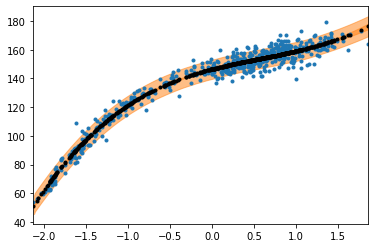

In [46]:
plt.plot(df_weights, df['height'], '.')
ax = az.plot_hdi(df_weights, mu_pred, hdi_prob=0.84)
az.plot_hdi(df_weights, heights_pred.posterior_predictive['height'], ax=ax, hdi_prob=0.84)
plt.plot(df_weights, mu_pred.mean(axis=0).mean(axis=0), '.', color='black')
plt.xlim(df_weights.min(), df_weights.max());
plt.show()

Splines

In [65]:
cherry = pd.read_csv("/content/pymc-resources/Rethinking_2/Data/cherry_blossoms.csv")
cherry

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1,802,NaN,NaN,NaN,NaN
2,803,NaN,NaN,NaN,NaN
3,804,NaN,NaN,NaN,NaN
4,805,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1210,2011,99.0,NaN,NaN,NaN
1211,2012,101.0,NaN,NaN,NaN
1212,2013,93.0,NaN,NaN,NaN
1213,2014,94.0,NaN,NaN,NaN


# Problems

## 4M1. 
For the model definition below, simulate observed y values from the prior (not the posterior).

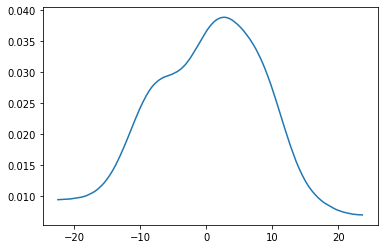

In [61]:
size = 100
sigma = stats.expon.rvs(1, size=size)
mu = stats.norm.rvs(loc=0, scale=10, size=size) 
y = stats.norm.rvs(loc=mu, scale=sigma, size=size)
plt.plot(*az.kde(y))
plt.show()

In [63]:
with pm.Model() as m_4m2: 
  sigma = pm.Exponential("sigma", lam=1)
  mu = pm.Normal("mu", mu=0, sigma=10)
  y = pm.Normal('y', mu=mu, sigma=sigma)
  trace_4_4m2 = pm.sample(1000, tune=1000)

ERROR:pymc:There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 105 divergences after tuning. Increase `target_accept` or reparameterize.


## 4M4. 
A sample of students is measured for height each year for 3 years. After the third year, you want
to fit a linear regression predicting height using year as a predictor. Write down the mathematical
model definition for this regression, using any variable names and priors you choose. Be prepared to
defend your choice of priors

In [ ]:
# year ~ uniform(0, 3)
# a ~ normal(150, 20)
# b ~ lognormal(0, 10)
# mu = a + year*b
# sigma ~ uniform(0, 30)
# height ~ normal(mu, sigma)

# 4M5. 
Now suppose I remind you that every student got taller each year. Does this information lead
you to change your choice of priors? How?

No - b lognormal factors for this

## 4M6. 
Now suppose I tell you that the variance among heights for students of the same age is never
more than 64cm. How does this lead you to revise your priors?

Yes: sigma ~ uniform(0, 8) (std = sqrt var = sqrt(64) = 8)

## 4M7. 
Refit model m4.3 from the chapter, but omit the mean weight xbar this time. Compare the
new model’s posterior to that of the original model. In particular, look at the covariance among the
parameters. What is different? Then compare the posterior predictions of both models

In [148]:
with pm.Model() as m4_42b:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50, initval=df2['height'].std())
    mu = a + b*(df2['weight'].values - df2['weight'].mean())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df2['height'].values)
    trace_4_42b = pm.sample(1000, tune=1000)


In [68]:
az.summary(trace_4_42, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,154.6,0.27,154.11,155.10
b,0.9,0.04,0.83,0.98
sigma,5.1,0.20,4.74,5.48


In [69]:
az.summary(trace_4_42b, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,114.59,2.06,110.77,118.44
b,0.89,0.05,0.81,0.98
sigma,5.10,0.20,4.76,5.51


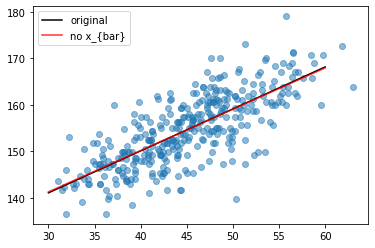

In [72]:
plt.plot(df2['weight'], df2['height'], 'o', alpha=0.5)
a = trace_4_42.posterior['a'].mean().values
b = trace_4_42.posterior['b'].mean().values
x_val = np.linspace(30, 60, 100)
plt.plot(x_val, a+b*(x_val-df2['weight'].mean()), color='black', label="original")
a = trace_4_42b.posterior['a'].mean().values
b = trace_4_42b.posterior['b'].mean().values
plt.plot(x_val, a+b*(x_val), color='red', alpha=0.8, label="no x_{bar}")
plt.legend()
plt.show()

## 4M8. 
In the chapter, we used 15 knots with the cherry blossom spline. Increase the number of knots
and observe what happens to the resulting spline. Then adjust also the width of the prior on the
weights—change the standard deviation of the prior and watch what happens. What do you think
the combination of knot number and the prior on the weights controls?

## H1. 
The weights listed below were recorded in the !Kung census, but heights were not recorded for
these individuals. Provide predicted heights and 89% intervals for each of these individuals. That is,
fill in the table below, using model-based predictions.

In [167]:
weights = np.array([46.95, 43.72, 64.78, 32.59, 54.63])

with pm.Model() as m_4h1:
  a = pm.Normal('a', mu=178, sigma=20)
  b1 = pm.Lognormal('b1', mu=0, sigma=1)
  sigma = pm.Uniform('sigma', lower=0, upper=50)
  mu = pm.Deterministic("mu", a + b1*df_weights.values)
  h = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'].values)
  mean_vals = pm.find_MAP()

weights_norm = (weights-df2['weight'].mean())/df2['weight'].std()
height_pred = mean_vals['a'] + mean_vals['b1']*weights_norm.T
print(height_pred)


[146.15267627 133.17475137 217.79242893  88.45515254 177.01040484]


## 4H2. 
Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right,
you should end up with a new data frame with 192 rows in it.
* (a) Fit a linear regression to these data, using quap. Present and interpret the estimates. For
every 10 units of increase in weight, how much taller does the model predict a child gets?
* (b) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Super-
impose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval
for predicted heights.
* (c) What aspects of the model fit concern you? Describe the kinds of assumptions you would
change, if any, to improve the model. You don’t have to write any new code. Just explain what the
model appears to be doing a bad job of, and what you hypothesize would be a better model.

In [122]:
df_u18 = df[df['age']<18]
len(df_u18)

192

In [193]:
with pm.Model() as m_4h2:
  a = pm.Normal("a", mu=0, sigma=15)
  b = pm.Lognormal("b", mu=0, sigma=1)
  mu = pm.Deterministic("mu", a + b* (df_u18['weight'].values - df_u18['weight'].mean()))
  sigma = pm.Uniform("sigma", lower=0, upper=40)
  height = pm.Normal("height", mu=mu, sigma=sigma, observed=df_u18['height'].values)
  trace_ = pm.sample(1000, tune=1000)
  mean_vals = pm.find_MAP()

In [222]:
mean_vals['b']*10

26.418550477773483

In [196]:
trace__ = az.extract_dataset(trace_)

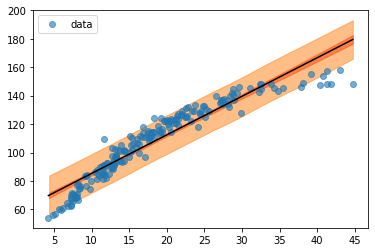

In [221]:
N = 100
weight_range = (df_u18['weight'].min(), df_u18['weight'].max())
weights = np.linspace(*weight_range, N)
n_samples = trace__.sizes['sample']

mu_pred = np.zeros((len(weights), n_samples))
for i, weight in enumerate(weights):
  mu_pred[i] = trace__['a'] + trace__['b']*(weight - df_u18['weight'].mean())

with m_4h2:
  height_preds = pm.sample_posterior_predictive(trace_)
  
plt.plot(df_u18['weight'], df_u18['height'], 'o', alpha=0.6, label="data")
plt.plot(
    weights, mu_pred.mean(axis=1), 'black')
ax = az.plot_hdi(weights, mu_pred.T, hdi_prob=0.89, color='red')
az.plot_hdi(df_u18['weight'], height_preds['posterior_predictive']['height'], ax=ax, hdi_prob=0.89)
plt.legend()
plt.show()

I think the assumption that the data is a linear trend may need more consideration. Looking at the data, it may be quadratic (though we don't want to fall into the mistake of only basing our moedl on the data)
